# Loading projectile data

The data is 100 projectiles all in one csv.

In [1]:
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
data = np.loadtxt(open("projectiles.csv", "rb"), delimiter=",")

Breaking down into individual examples and ignoring time (equally spaced at 100ms),

In [2]:
def separate_projectiles(data):
    data2 = np.delete(data, 0, axis=1) # delete col 1
    n = len(data2)
    res = []
    for i in range(n):
        curr = data2[i]
        if (curr == [0, 0]).all():
            res.append([curr])
        else:
            res[-1].append(curr)
    return np.array(res)

examples = separate_projectiles(data)

Verify we have 100 examples, i.e. separation was fine.

In [3]:
len(examples)

100

# Visualize data

Let's see if the projectiles look okay. With matplotlib, we can do something like

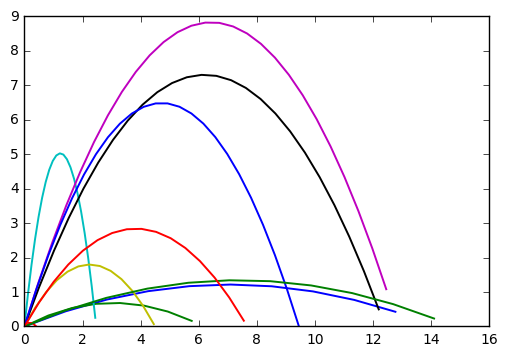

In [4]:
import matplotlib.pyplot as plt

# visualize projectile curve
def show_projectile(points):
    np_points = np.array(points)
    plt.plot(np_points[:, 0], np_points[:, 1], linewidth=1.4)

# shuffle data
def shuffle(data):
    return np.random.shuffle(data)
    
# visualize random 10 projectiles
shuffle(examples)
for i in range(10):
    show_projectile(examples[i])
plt.show()

# Approach 1 (using domain knowledge)

Domain knowledge dictates that the projectile follows a quadratic curve $a_2x^2+a_1x^1+a_0$ that depends on $\vec{a}$ and $\vec{u}$. Since $\vec{a}$ is constant, and first two points give away the $\vec{u}$, we can use a neural net that takes 2 inputs $x_1,y_1$ and works out the curve parameters $a_2,a_1,a_0$.  


## Problems

1. How many layers? And how many hidden nodes in each layer?

2. Even when the curve is predicted, we'll have to use the equations of motion to find out the points on the curve every time step (100ms)

3. There are too few actual examples. If we remove sequences with length <= 5, there are only 78 sequences.


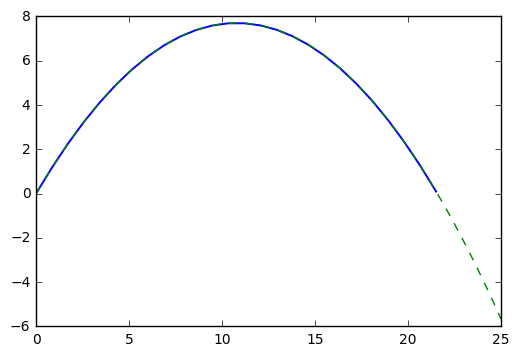

In [19]:
# fit a quadratic curve for given sample projectile
def get_curve_params(example):
    example = np.array(example)
    return np.polyfit(example[:, 0], example[:, 1], 2)

# plot quadratic curve
def show_curve(curve_params):
    x = np.linspace(0, 25, 100)
    plt.plot(x, curve_params[0]*(x**2)+curve_params[1]*x+curve_params[2], 'g--')
    plt.show()

random_idx = np.random.randint(0, 100)
show_projectile(examples[random_idx])
show_curve(get_curve_params(examples[random_idx]))
# you may need to run this cell again if output looks fishy ... that happens
# because some examples have as less as 2 points - the quadratic curve predicted
# looks weird then

Examples = 78
Epoch 0: error = 1.391360
Epoch 1000: error = 0.029500
Epoch 2000: error = 0.031141
Epoch 3000: error = 0.030000
Epoch 4000: error = 0.055693


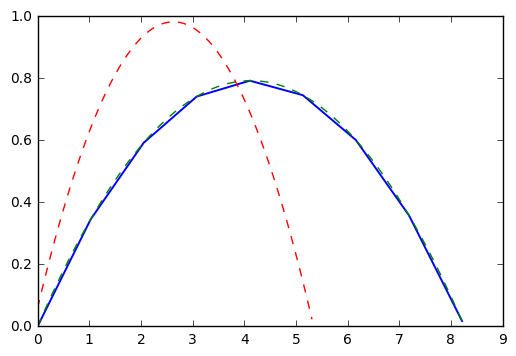

In [53]:
# plot quadratic curve (modified)
def show_curve2(curve_params, x_max, color = 'g--'):
    x = np.linspace(0, x_max, 100)
    y = curve_params[0]*(x**2)+curve_params[1]*x+curve_params[2]
    y = [el for el in y if el > 0]
    x = x[:len(y)]
    plt.plot(x, y, color)
    
def MLP(I, W, B): # inputs, weights, biases

    H = tf.nn.relu(tf.matmul(I, W[0])+B[0])
    O = tf.matmul(H, W[1])+B[1]

    return O

def MLP_var(shape):

    return tf.Variable(tf.random_normal(shape, 0, 0.1))

mlp_h = 64 # nodes in hidden layer
mlp_train_size = 65 # training size
mlp_test_size = 13 # testing size
shuffle(examples)
mlp_data = examples
mlp_data = [el for el in mlp_data if (np.abs(get_curve_params(el)) <= 1e3).all() \
               and len(get_curve_params(el)) == 3 \
               and len(el) > 5 ]
print("Examples = %d" % len(mlp_data))
mlp_dataX = np.array([el[1] for el in mlp_data])
mlp_datay = np.array([get_curve_params(el) for el in mlp_data])

mlp_train_dataX = mlp_dataX[:mlp_train_size]
mlp_train_datay = mlp_datay[:mlp_train_size]
mlp_test_dataX = mlp_dataX[mlp_train_size:]
mlp_test_datay = mlp_datay[mlp_train_size:]
mlp_epochs = 5000
mlp_G = tf.Graph()

with mlp_G.as_default():

    mlp_alpha = 0.1 # learning rate

    mlp_tr_x = tf.placeholder(tf.float32, [None, 2])
    mlp_tr_y = tf.placeholder(tf.float32, [None, 3])
    mlp_te_x = tf.placeholder(tf.float32, [None, 2])
    mlp_W = [MLP_var([2, mlp_h]), MLP_var([mlp_h, 3])]
    mlp_B = [MLP_var([mlp_h]), MLP_var([3])]

    mlp_predictions = MLP(mlp_tr_x, mlp_W, mlp_B)
    mlp_E = tf.reduce_mean(tf.square(mlp_predictions-mlp_tr_y))
    mlp_opt = tf.train.AdamOptimizer(mlp_alpha).minimize(mlp_E)

    mlp_pred_te_y = MLP(mlp_te_x, mlp_W, mlp_B)

with tf.Session(graph=mlp_G) as session:

    session.run(tf.global_variables_initializer())

    for j in range(mlp_epochs):
        perm = np.random.permutation(mlp_train_size)
        mlp_train_dataX = mlp_train_dataX[perm]
        mlp_train_datay = mlp_train_datay[perm]
        nn = mlp_train_size/5
        for bi in range(5):
            feed = {mlp_tr_x: mlp_train_dataX[bi*nn:bi*nn+nn], 
                    mlp_tr_y: mlp_train_datay[bi*nn:bi*nn+nn]}
            _, eee, ppp = session.run([mlp_opt, mlp_E, mlp_predictions],
                                      feed_dict = feed)
        if j%1000 == 0:
          if np.isnan(eee):
                print("got nan ... ")
          print("Epoch %d: error = %f" % (j, eee))

    ri = np.random.randint(0, mlp_test_size)
    while len(mlp_data[mlp_train_size+ri]) <= 5:
        ri = np.random.randint(0, mlp_test_size)
    mlp_random_case = mlp_test_dataX[ri]
    mlp_curve_params = mlp_test_datay[ri]
    x_max = mlp_data[mlp_train_size+ri][-1][0]
    mlp_predicted_params = mlp_pred_te_y.eval(feed_dict = {
        mlp_te_x: [mlp_random_case]
    })[0]
    show_projectile(mlp_data[mlp_train_size+ri])
    show_curve2(mlp_predicted_params, x_max, 'r--')
    show_curve2(mlp_curve_params, x_max, 'g--')
    plt.show()

A simple NN is not good enough, and fares badly in this case. (red dotted line = predicted curve)

# Approach 2 (Recurrent Neural Net)

If the problem is reframed, we might be able to reduce it to sequence prediction.

**Now**: Given initial two points, predict the next points so as to form a curve.  
**Reframed**: Given sequential training data of the form 
$$X=(x_1,y_1)\rightarrow(x_2,y_2)\rightarrow \dots (x_n,y_n)$$  
which leads to the next point $y=(x_{n+1},y_{n+1})$, learn how to predict $y$. This can then be used in quick succession to generate a set of points after the first two points, thereby giving away the projectile.

The reframed problem can be solved using dynamic RNN (dynamic because the sequence lengths are variable).

## Example

Consider a projectile path with 6 points $P_1,P_2,P_3,P_4,P_5$ and $P_6$. After separating the 100 projectiles in the input file, this may look like

```
[P1,P2,P3,P4,P5,P6]
```

Using the reframed problem statement, we can convert this representation to look like

```
[P1] -> P2
[P1,P2] -> P3
[P1,P2,P3] -> P4
[P1,P2,P3,P4] -> P5
[P1,P2,P3,P4,P5] -> P6
```
Specifically, an example with $n$ points produces $n-1$ examples in the reframed case. This logic for 100 examples (each of variable length) produces 1325 sequence examples.

## Generating batches of data

To abstract away heavylifting, lets have a class generate batches.

In [6]:
class ProjectileData:
    def __init__(self):
        data = np.loadtxt(open("projectiles.csv", "rb"), delimiter=",")\
                 .astype(np.float32)
        self.orig_examples = np.array(self.separate_projectiles(data))
        self.examples = self.shuffle(self.orig_examples)
        self.examples_no_time = self.examples
        self.max_points = 50
        self.batch_size = 25
        self.curr_batch = 0
        self.test_batch = 0
        # with a batch_size of 25, 1325 examples = 53 batches
        # use 50 batches for training, 3 for testing

        self.X = []
        self.y = []
        self.seqlens = []

        # pts are [1, 2, 3]
        # [1] -> [2]
        # [1, 2] -> [3]
        n_examples = len(self.examples)
        for e_idx in range(n_examples):
            e_len = len(self.examples[e_idx])
            for i in range(1, e_len):
                self.X.append(self.pad_example(self.examples[e_idx][:i], 
                                               self.max_points-i))
                self.y.append(self.examples_no_time[e_idx][i])
                self.seqlens.append(i)

        print("Total Examples = %d" % len(self.X))
        self.num_batches_train = len(self.X)/self.batch_size - 3
        self.num_batches_test = 3

    # return X, y, seqlens for next batch of examples (training)
    def next_batch(self):
        bid = self.curr_batch
        new_bid = (bid+1)%self.num_batches_train
        bN = self.batch_size
        if new_bid == 0:
            bX = self.X[bid*bN:]
            by = self.y[bid*bN:]
            bseqlens = self.seqlens[bid*bN:]
        else:
            bX = self.X[bid*bN:new_bid*bN]
            by = self.y[bid*bN:new_bid*bN]
            bseqlens = self.seqlens[bid*bN:new_bid*bN]
        self.curr_batch = new_bid
        return bX, by, bseqlens

    def next_test_batch(self):
        bid = self.test_batch
        new_bid = (bid+1)%self.num_batches_test
        bN = self.batch_size
        before = self.num_batches_train*bN # training examples overlooked
        if new_bid == 0:
            bX = self.X[before+bid*bN:]
            by = self.y[before+bid*bN:]
            bseqlens = self.seqlens[before+bid*bN:]
        else:
            bX = self.X[before+bid*bN:before+new_bid*bN]
            by = self.y[before+bid*bN:before+new_bid*bN]
            bseqlens = self.seqlens[before+bid*bN:before+new_bid*bN]
        self.test_batch = new_bid
        return bX, by, bseqlens


    # 100 x points x 3 (where points <= 50)
    def separate_projectiles(self, data, delete_time_axis=True):
        start = [0, 0, 0]
        if delete_time_axis:
            data = np.delete(data, 0, axis=1) # delete col 1
            start = [0, 0]
        n = len(data)
        res = []
        for i in range(n):
            curr = data[i]
            if (curr == start).all():
                res.append([curr])
            else:
                res[-1].append(curr)
        return np.array(res)

    # shuffle data
    def shuffle(self, d):
        return np.random.permutation(d)

    # pad with dummy points (will not learn from these points)
    def pad_example(self, x, extra):
        local_n = len(x)
        paddings = [np.array([0., 0.]) for i in range(extra)]
        tmp_x = x[:]
        tmp_x.extend(paddings)
        return tmp_x

    # returns a string representation of X (training/testing)
    def format_X(self, X):
        strs = [element.__str__() for element in X]
        return '\n'.join(strs)

Let's see how a batch looks. A batch is padded to have dimensions $(batch\_size, 50, 2)$. 50 is chosen because there are no examples where the number of points exceed 50.

In [7]:
dataset = ProjectileData()

# Uncomment and run next line to see how the examples look
#dataset.next_batch()

Total Examples = 1325


Defining our RNN parameters,

In [8]:
alpha = 0.01
nH = 64 # hidden layers
nO = 2 # outputs
batch_size = 25
seq_size = 50 # padded sequence size

Creating our RNN with single `BasicLSTMCell`,

In [9]:
G = tf.Graph()

with G.as_default():
    
    # batch_size, seq_size, coordinates
    X = tf.placeholder(tf.float32, [None, seq_size, 2])
    # batch_size, output_coordinates
    y = tf.placeholder(tf.float32, [None, 2])
    # batch_size
    seqlen = tf.placeholder(tf.int32, [None])

    W = tf.Variable(tf.random_normal([nH, nO]))
    B = tf.Variable(tf.random_normal([nO]))

    # seq_size, batch_size, coordinates
    X1 = tf.transpose(X, [1, 0, 2])
    # seq_size * batch_size, coordinates
    X1 = tf.reshape(X1, [-1, 2])
    # get 50 tensors of shape batch_size, coordinates
    X1 = tf.split(0, 50, X1)

    cell = tf.nn.rnn_cell.BasicLSTMCell(nH)

    outputs, states = tf.nn.rnn(cell, X1, dtype=tf.float32, 
                                sequence_length=seqlen)

    outputs = tf.pack(outputs)
    # batch_size, seq_size, coordinates
    outputs = tf.transpose(outputs, [1, 0, 2])

    # retaking batch_size because sometimes we might need to pass 
    # in a different batch size
    batch_size2 = tf.shape(outputs)[0]
    indices = tf.range(0, batch_size2)*seq_size + (seqlen - 1)
    outputs = tf.gather(tf.reshape(outputs, [-1, nH]), indices)

    pred = tf.matmul(outputs, W) + B

    # squared sum error per example
    E = tf.reduce_mean(tf.square(pred-y))
    # optimizer
    opt = tf.train.GradientDescentOptimizer(alpha).minimize(E)
    
    init = tf.global_variables_initializer()

We can train our optimizer something like (more steps = better prediction)

In [10]:
session = tf.Session(graph = G)
session.run(init)

In [11]:
num_epochs = 30000

for epoch in range(num_epochs):
    bX, by, bseqlens = dataset.next_batch()
    bX = np.array(bX)
    by = np.array(by)
    bseqlens = np.array(bseqlens)
    session.run(opt, feed_dict = {
        X: bX, 
        y: by, 
        seqlen: bseqlens
    })
    bE = session.run(E, feed_dict = {X: bX, y: by, seqlen: bseqlens})

    if epoch%500 == 0:
        print("Epoch %d: E = %f" % (epoch, bE))

print("Optimization complete!")

Epoch 0: E = 25.952000
Epoch 500: E = 0.097756
Epoch 1000: E = 0.069557
Epoch 1500: E = 0.044849
Epoch 2000: E = 0.042026
Epoch 2500: E = 0.036245
Epoch 3000: E = 0.043059
Epoch 3500: E = 0.033119
Epoch 4000: E = 0.036854
Epoch 4500: E = 0.031264
Epoch 5000: E = 0.027928
Epoch 5500: E = 0.027092
Epoch 6000: E = 0.027473
Epoch 6500: E = 0.024739
Epoch 7000: E = 0.023284
Epoch 7500: E = 0.021700
Epoch 8000: E = 0.020882
Epoch 8500: E = 0.020331
Epoch 9000: E = 0.019972
Epoch 9500: E = 0.019510
Epoch 10000: E = 0.027480
Epoch 10500: E = 0.020269
Epoch 11000: E = 0.018519
Epoch 11500: E = 0.017829
Epoch 12000: E = 0.017516
Epoch 12500: E = 0.017300
Epoch 13000: E = 0.017125
Epoch 13500: E = 0.016960
Epoch 14000: E = 0.016780
Epoch 14500: E = 0.016590
Epoch 15000: E = 0.016403
Epoch 15500: E = 0.016227
Epoch 16000: E = 0.016067
Epoch 16500: E = 0.015921
Epoch 17000: E = 0.015780
Epoch 17500: E = 0.015648
Epoch 18000: E = 0.015551
Epoch 18500: E = 0.015460
Epoch 19000: E = 0.015361
Epoch 195

Since this is not a class prediction problem, it is difficult to measure the accuracy for our test cases (accuracy measures rely on the fact the we predict something correctly or wrongly).

A good accuracy measure could be the fact that we predict our $y$ within say $10^{-2}$ of the actual value, for both coordinates in $y$.

However, let's see our predictions to get an idea of what our model is predicting. For the 3 test batches:

In [32]:
show_test_cases = 3
shown_test_cases = 0
for batch_idx in range(3):
    # Uncomment next line and increase show_test_cases to 75 to see all test cases
    #print("Testing (batch %d)" % batch_idx)
    bX, by, bseqlens = dataset.next_test_batch()
    bX = np.array(bX)
    by = np.array(by)
    bseqlens = np.array(bseqlens)
    test_pred = session.run(pred, feed_dict = {
        X: bX, 
        y: by, 
        seqlen: bseqlens
    })

    n_test = len(test_pred)
    for i in range(n_test):
        if shown_test_cases < show_test_cases:
            print("Test %d:" % i)
            print(dataset.format_X(bX[i][:bseqlens[i]])+" -> "+\
                  by[i].__str__()+"\npredicted = "+\
                  test_pred[i].__str__()+"\n")
            shown_test_cases += 1

Test 0:
[ 0.  0.]
[ 0.24270509  0.12733558]
[ 0.48541018  0.15667115] -> [ 0.72811532  0.08800673]
predicted = [ 0.79742432  0.00189877]

Test 1:
[ 0.  0.] -> [ 0.50795048  1.14765632]
predicted = [ 0.61817622  0.6031028 ]

Test 2:
[ 0.  0.]
[ 0.50795048  1.14765632] -> [ 1.01590097  2.19731259]
predicted = [ 1.05850804  2.15519381]



# Visualizing our results

Let's choose a random example, construct $X,y,seqlens$ for it, and by successive predictions, predict the projectile curve.

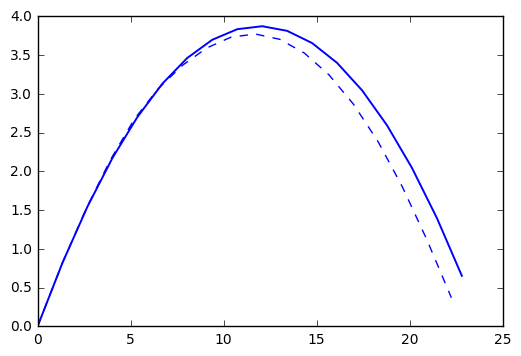

In [13]:
random_i = np.random.randint(0, 100)
ex = dataset.examples[random_i]
e_len = len(ex)
tmpX = []
tmpy = []
tmpseqlens = []
pred_pts = [ex[0], ex[1]] # except the first 2 pts
for i in range(2, e_len):
    tmpX.append(dataset.pad_example(pred_pts[:i], 50-i))
    tmpy.append(ex[i]) # bogus
    tmpseqlens.append(i)
    test_pred = session.run(pred, feed_dict = {
        X: np.array(tmpX), 
        y: np.array(tmpy), 
        seqlen: np.array(tmpseqlens)
    })
    pred_pts.append(test_pred[-1])

np_points1 = np.array(ex)
plt.plot(np_points1[:, 0], np_points1[:, 1], linewidth=1.4)
np_points2 = np.array(pred_pts)
plt.plot(np_points2[:, 0], np_points2[:, 1], 'b--')
plt.show()

Results may not be very accurate.

# Discussion (Q2)

#### What made you choose this specific model? Is your model well suited to the learning objective?

The problem statement is a sequence prediction problem, with inputs at every time step (100ms). Another such problem I could think of is implementing autocomplete on a series of words (i.e. predicting the next words). Generally such problems are well suited to RNNs.

#### How would you evaluate your model?  

Testing accuracy is easier when predicted $y$ is a class label. A good accuracy measure I can think of for this problem could be the Euclidean distance between predicted $y=(a,b)$ and actual $y=(c,d)$.

$$dist = \sqrt{(a-c)^2+(b-d)^2}$$

and then defining a small *circle of accuracy* near the predicted $y$, of radius $R$. So, if $dist \leq R$, our model predicted $y$ well, else not. $R$ could be say, 0.1, as a good enough measure.

#### Can your model predict projectiles launched at arbitrary angles and velocities equally well (or badly)?  

As a test, let's consider three test cases for arbitrary angles and arbitrary velocities.

(a) <u>Arbitrary Angles</u>

Say $u=10$ m/s and angles are $30^{\circ}, 50^{\circ}, 70^{\circ}$. The model seems good for arbitrary angles. Even $30^{\circ}$ and $60^{\circ}$ almost cover the same horizontal distance.

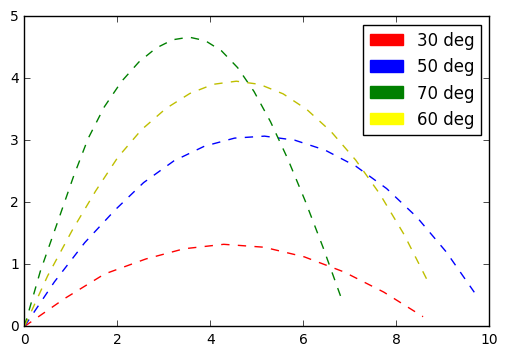

In [26]:
import matplotlib.patches as mpatches

def predict(pt_x, pt_y, num_pts = 10, color='b--'):
    tmpX = []
    tmpy = []
    tmpseqlens = []
    pred_pts = [np.array([0.,0.]), np.array([pt_x, pt_y])] # except the first 2 pts
    for i in range(2, num_pts):
        tmpX.append(dataset.pad_example(pred_pts[:i], 50-i))
        tmpy.append(np.array([0.,0.])) # bogus
        tmpseqlens.append(i)
        test_pred = session.run(pred, feed_dict = {
            X: np.array(tmpX), 
            y: np.array(tmpy), 
            seqlen: np.array(tmpseqlens)
        })
        if test_pred[-1][1] < 0: break
        pred_pts.append(test_pred[-1])

    np_points = np.array(pred_pts)
    plt.plot(np_points[:, 0], np_points[:, 1], color)
    return np_points


angles = [30, 50, 70, 60]
colors = ['r--', 'b--', 'g--', 'y--']
for angle_idx in range(len(angles)):
    angle = angles[angle_idx]
    pt_x = 10*np.cos(angle*np.pi/180.)*0.1
    pt_y = 10*np.sin(angle*np.pi/180.)*0.1-4.9*0.01
    predict(np.float32(pt_x), np.float32(pt_y), color = colors[angle_idx], num_pts = 20)

red_label = mpatches.Patch(color='red', label='30 deg')
blue_label = mpatches.Patch(color='blue', label='50 deg')
green_label = mpatches.Patch(color='green', label='70 deg')
yellow_label = mpatches.Patch(color='yellow', label='60 deg')
plt.legend(handles=[red_label, blue_label, green_label, yellow_label])
plt.show()

(b) <u>Arbitrary Velocities</u>

Say $\theta=30^{\circ}$ and velocities are are $5, 10, 15$ m/s. The model seems okayish for arbitrary velocities as well.

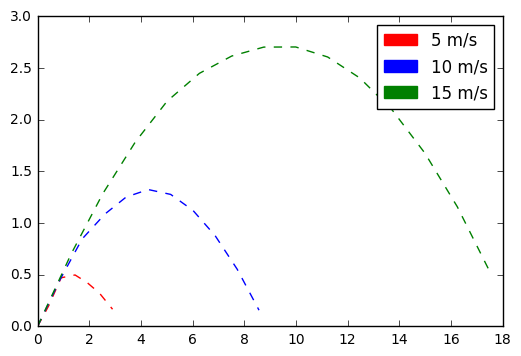

In [27]:
velocities = [5, 10, 15]
colors = ['r--', 'b--', 'g--']
for velocity_idx in range(len(velocities)):
    velocity = velocities[velocity_idx]
    pt_x = velocity*np.cos(30*np.pi/180.)*0.1
    pt_y = velocity*np.sin(30*np.pi/180.)*0.1-4.9*0.01
    predict(np.float32(pt_x), np.float32(pt_y), color = colors[velocity_idx], num_pts = 20)

red_label = mpatches.Patch(color='red', label='5 m/s')
blue_label = mpatches.Patch(color='blue', label='10 m/s')
green_label = mpatches.Patch(color='green', label='15 m/s')
plt.legend(handles=[red_label, blue_label, green_label])
plt.show()

#### What assumptions does your model make?  

Because the output curve was a simple pattern (parabola), the model uses a single cell with default config (1 hidden layer). For more complicated patterns, this model may not be good enough.

#### Will your approach/model change if we hadn’t told you that the data was from a projectile?  

Yes. I would probably use more cells, or a different type of cell, or maybe even a different model.

#### Did you refer to any relevant literature while solving this problem?  

Somewhat. I had not implemented a dynamic sequence RNN in Tensorflow before, so I had to refer to Tensorflow docs. Andrej Karpathy's blog was also very helpful.

#### If you were given enough time, how would you improve the model?  

Maybe by:

1. Using a different cell (eg. GRU)
2. Using a different optimizer (eg. AdamOptimizer)
3. Using a variable learning rate
4. Using a different model, maybe from deep reinforcement learning (eg. Deep Q). The problem can also be thought of as a RL problem, where
  - start state is first point $(x_1,y_1)$
  - action is placing next point
  - reward could be (while going up) an increase in potential energy or (while going down) an increase in kinetic energy
  - tuple of coordinates, energies could be states  
  
  A different interpretation is certainly possible.

# Generating results for given set of points (Q1)

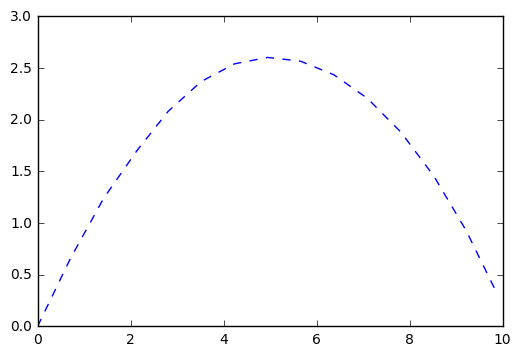

array([[ 0.        ,  0.        ],
       [ 0.70710677,  0.6581068 ],
       [ 1.42089534,  1.23948693],
       [ 2.13862324,  1.70265079],
       [ 2.80959821,  2.081954  ],
       [ 3.5194087 ,  2.37030768],
       [ 4.237113  ,  2.54177022],
       [ 4.94707155,  2.60344815],
       [ 5.65617085,  2.56693339],
       [ 6.3714056 ,  2.43555403],
       [ 7.09293652,  2.20768189],
       [ 7.8146534 ,  1.88022709],
       [ 8.52614212,  1.45235968],
       [ 9.21596527,  0.92864251],
       [ 9.8797493 ,  0.31978059]])

In [29]:
q1_pt_x, q1_pt_y = np.float32(0.707106781187), np.float32(0.658106781187)
ans = predict(q1_pt_x, q1_pt_y, num_pts=20)
plt.show()
ans